In [1]:
import openmc
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [2]:


TRISO = openmc.Model()

''' 
Materials 
'''

SiC = openmc.Material(1,name='SiC')
SiC.add_elements_from_formula('SiC')
SiC.set_density('g/cm3',3.2)

PyC = openmc.Material(2,name = 'PyC')
PyC.add_element('C',1)
PyC.set_density('g/cm3',1.9)

Carbon = openmc.Material(3,name = 'Carbon Buffer')
Carbon.add_element('C',1)
Carbon.set_density('g/cm3',1)

UCO = openmc.Material(4,name='Fuel')
UCO.add_element('U',3,enrichment=19.75,)
UCO.add_element('C',3)
UCO.add_element('O',2)
UCO.set_density('g/cm3',10.75)

TRISO.materials = openmc.Materials([SiC,PyC,Carbon,UCO])


'''
Geometry
'''

radius_fuel, radius_buffer, radius_IPyC, radius_SiC, radius_OPyC = 400e-4, 475e-4, 510e-4, 546.7e-4, 566.7e-4
compact_radius,compact_height = 20 * radius_OPyC, 1
compact_surface = openmc.ZCylinder(r = compact_radius, surface_id = 1,boundary_type = 'reflective')
top,bottom = openmc.ZPlane(z0 = compact_height/2,surface_id = 2,boundary_type ='reflective'), openmc.ZPlane(z0 = -compact_height/2, surface_id = 3,boundary_type = 'reflective')
compact_region =  -compact_surface & - top & + bottom
pf = .5

centroids = openmc.model.pack_spheres(radius = radius_OPyC,region=compact_region,pf=pf)






/opt/anaconda3/lib/python3.11/site-packages/openmc/material.py:790: UserWarning: A uranium enrichment of 19.75 was given for Material ID="4". OpenMC assumes the U234/U235 mass ratio is constant at 0.008, which is only valid at low enrichments. Consider setting the isotopic composition manually for enrichments over 5%.
  warnings.warn(msg)


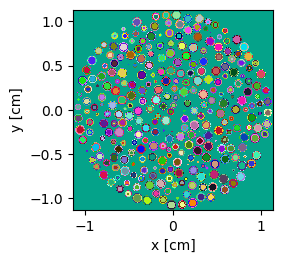

In [3]:
def triso_surfs(r,x,y,z):
    return openmc.Sphere(r=r,x0=x,y0=y,z0=z)
fuel_surfs = [triso_surfs(radius_fuel,x,y,z) for x,y,z in centroids]
buffer_surfs = [triso_surfs(radius_buffer,x,y,z) for x,y,z in centroids]
IPyC_surfs = [triso_surfs(radius_IPyC,x,y,z) for x,y,z in centroids]
SiC_surfs = [triso_surfs(radius_SiC,x,y,z) for x,y,z in centroids]
OPyC_surfs = [triso_surfs(radius_OPyC,x,y,z) for x,y,z in centroids]

compact_surface = openmc.model.HexagonalPrism(edge_length=compact_height*3,corner_radius=radius_OPyC,boundary_type='white')
index = len(fuel_surfs)

#f is fuel, b is buffer, ip is inner pyc, s is sic, op is opyc

fuel_cells = [openmc.Cell(cell_id=i,region = -f,fill = UCO) for i,f in enumerate(fuel_surfs)]
buffer_cells = [openmc.Cell(cell_id = i+index,region = +f&-b,fill = Carbon) for i,(f,b) in enumerate(zip(fuel_surfs,buffer_surfs))]
ipyc_cells = [openmc.Cell(cell_id = i+index*2,region = +b&-ip,fill = PyC) for i,(b,ip) in enumerate(zip(buffer_surfs,IPyC_surfs))]
sic_cells = [openmc.Cell(cell_id = i+index*3,region = +ip&-s,fill = SiC) for i,(ip,s) in enumerate(zip(IPyC_surfs,SiC_surfs))]
opyc_cells = [openmc.Cell(cell_id = i+index*4,region = +s&-op,fill = PyC) for i,(s,op) in enumerate(zip(SiC_surfs,OPyC_surfs))]

Matrix_region = +bottom &-top & - compact_surface
for op in OPyC_surfs:
    Matrix_region &= + op
Matrix_cell = openmc.Cell(region=Matrix_region,fill = Carbon)

#theres probably a better way to do this
cells = fuel_cells
cells.extend(buffer_cells)

cells.extend(ipyc_cells)

cells.extend(sic_cells)

cells.extend(opyc_cells)

cells.append(Matrix_cell)

universe = openmc.Universe(cells = cells)
TRISO.geometry = openmc.Geometry(universe)
universe.plot(width = (2*compact_radius,2*compact_radius))
save_path = r'/Users/nglaser3/Downloads/'
plt.savefig(save_path+'trisomesh.png',dpi = 600)
plt.show()

In [6]:
'''
Settings 
'''
TRISO.settings.source = openmc.IndependentSource(space=openmc.stats.Box(
    [-compact_radius, -compact_radius, -compact_height], [compact_radius, compact_radius, compact_height],only_fissionable=True))
TRISO.settings.batches = 400
TRISO.settings.inactive = 200
TRISO.settings.particles = 100000

flux_tally_zernike = openmc.Tally()
flux_tally_zernike.scores = ['kappa-fission']
zernike_filter = openmc.ZernikeFilter(order=50, x=0.0, y=0.0, r=compact_radius)
flux_tally_zernike.filters = [zernike_filter]
TRISO.tallies = openmc.Tallies([flux_tally_zernike])


In [7]:
TRISO.export_to_model_xml('BUrr.xml')